In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PImage #used for disk IO
from scipy import signal as sp_signal #allowed for 2d convolution

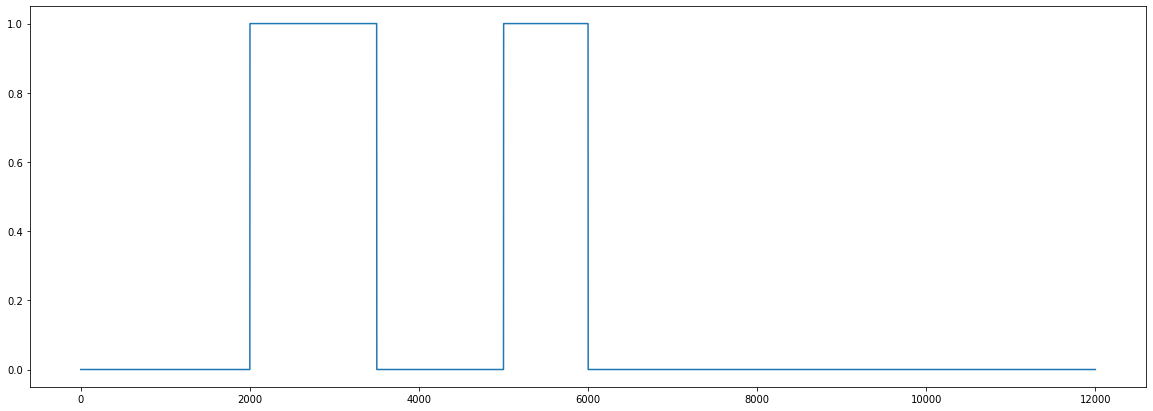

In [2]:
#Exercise 4.
#Task 1.
#Subtask a)

#1. Generate a signal
true_edges = [2000, 3500, 5000, 6000]
signal = np.zeros(12000)
signal[true_edges[0]:true_edges[1]] = 1.0
signal[true_edges[2]:true_edges[3]] = 1.0
plt.figure(figsize=(20,7))
plt.plot(signal)

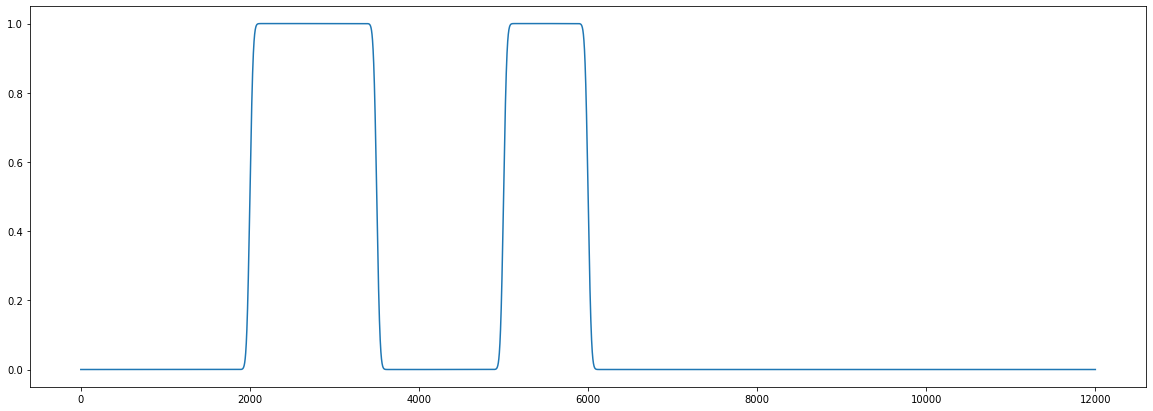

In [3]:
#2. Apply gaussian filter

def nth_gradient(X, n = 0):
    """
    N-th numerical differention
    """
    grad = X
    if n > 0:
        for i in range(n):
            dx = np.abs(np.sum(X)/len(X))
            grad = np.gradient(grad, dx)
            #print(dx)
    return grad

def get_kernel(sz, mu=0.0, sigma=0.5, sum_one=False, derivative = 0):
    """
    Differentable kernel θ  with integral == 1
    """
    #2.1 Construct kernel
    kernel = np.linspace(-10.0,10.0,sz)
    kernel = np.exp(-(((kernel-mu)**2.0)/(2.0*sigma**2)))
    
    if derivative >= 1.0:
        kernel = nth_gradient(kernel, derivative)

    #2.2 If integral == 1 is required
    if sum_one:
        kernel = kernel/sum(kernel)
        
    return kernel
        
def gaussian_smoothening(signal, mu=0.0, sigma=0.05, sum_one=False, derivative = 0):
    """
    Guassian smoothing function via FFT.
    Produces "smoother" edges than just convolving with the kernel.
    """
    #2.1 FFT
    signal_transformed = np.fft.fft(signal)
    signal_amplitude = np.abs(signal_transformed),
    signal_angle = np.angle(signal_transformed)
    signal_phase = np.exp(1j*signal_angle)
    signal_amplitude = np.fft.fftshift(signal_amplitude)

    #2.2 Construct kernel
    kernel = get_kernel(len(signal), mu=mu, sigma=sigma, sum_one=sum_one, derivative = derivative)

    #2.3 Apply kernel and reconstruct signal
    signal_amplitude = (kernel*signal_amplitude)[0]
    signal_amplitude = np.fft.ifftshift(signal_amplitude)
    signal_filtered = np.real(np.fft.ifft(signal_amplitude*signal_phase))
    return signal_filtered
#signal_filtered = gaussian_smoothening(signal, 0.0, 0.05, True, 0) # Produces 'better' (smoother) result
kernel = get_kernel(1200, 0.0, 0.5, True, 0) #best result for sigma = 0.5 instead of 5.0
signal_filtered = np.convolve(signal, kernel, 'same') #can also done by convolving the kernel
plt.figure(figsize=(20,7))
plt.plot(signal_filtered)

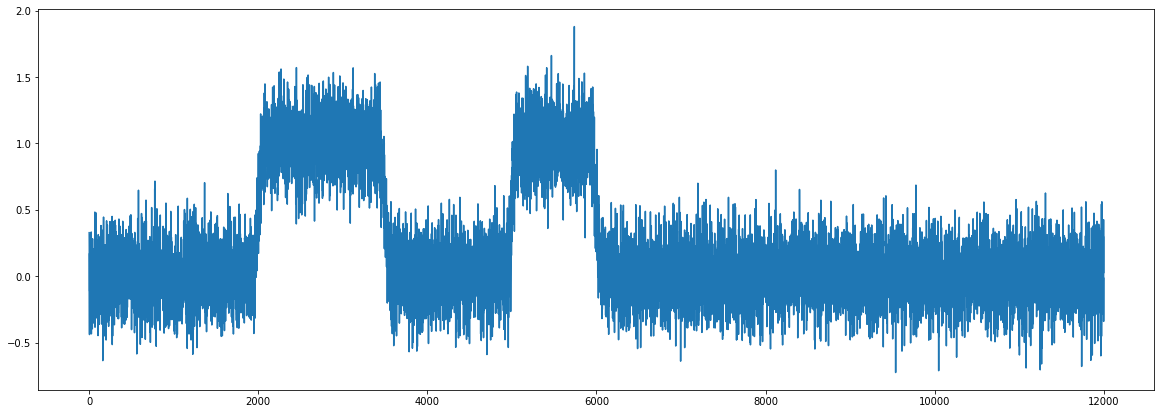

In [4]:
#3. Add noise
noise = np.random.normal(0.0,0.2,len(signal_filtered))
signal_filtered_noisy = signal_filtered+noise
plt.figure(figsize=(20,7))
plt.plot(signal_filtered_noisy)

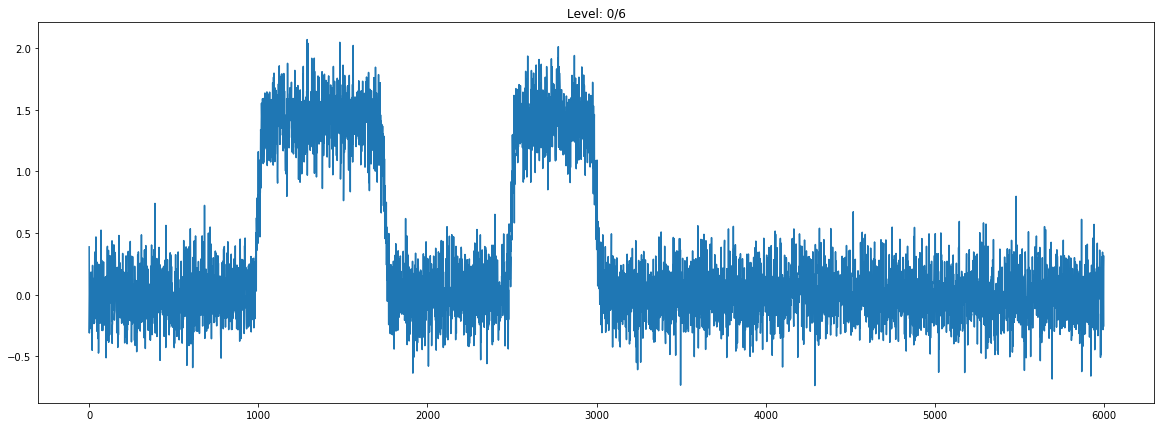

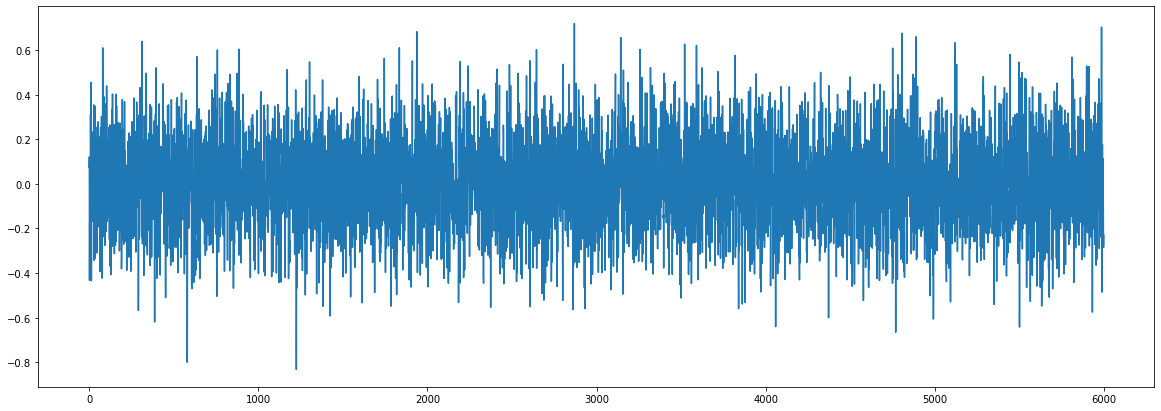

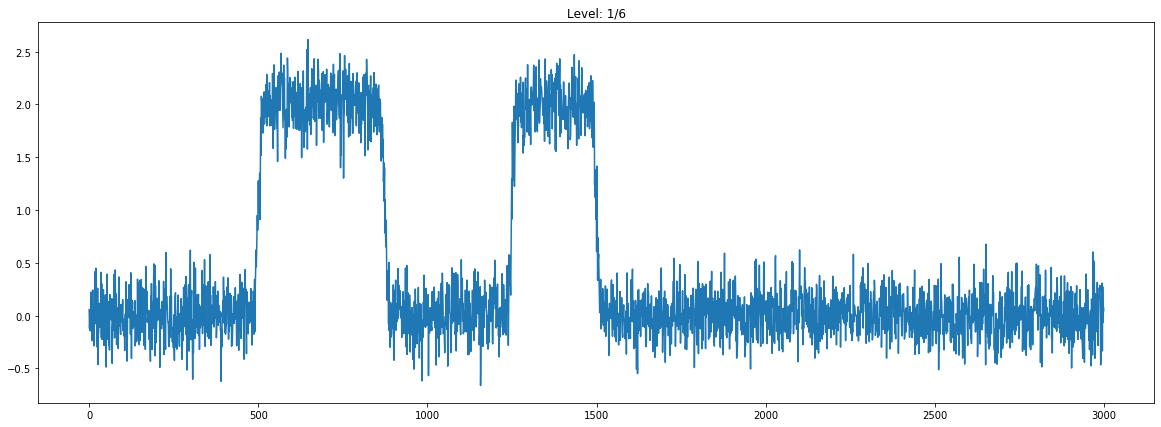

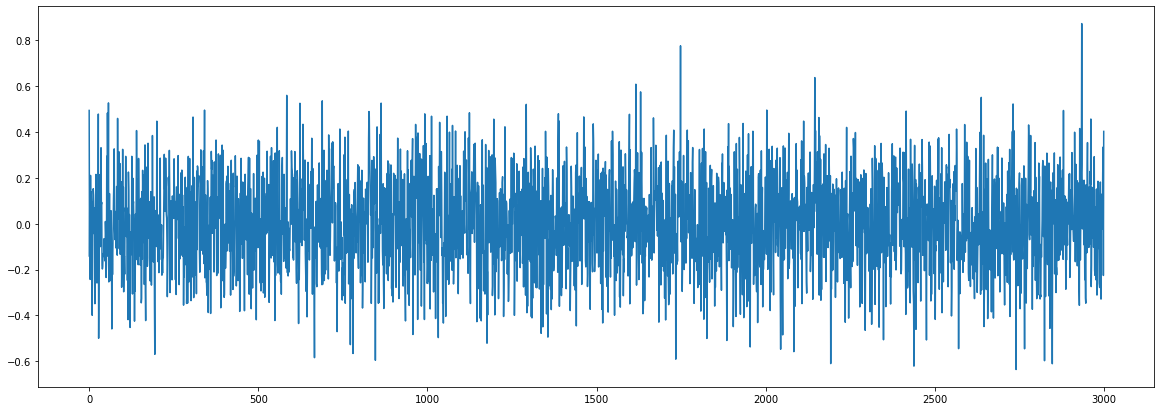

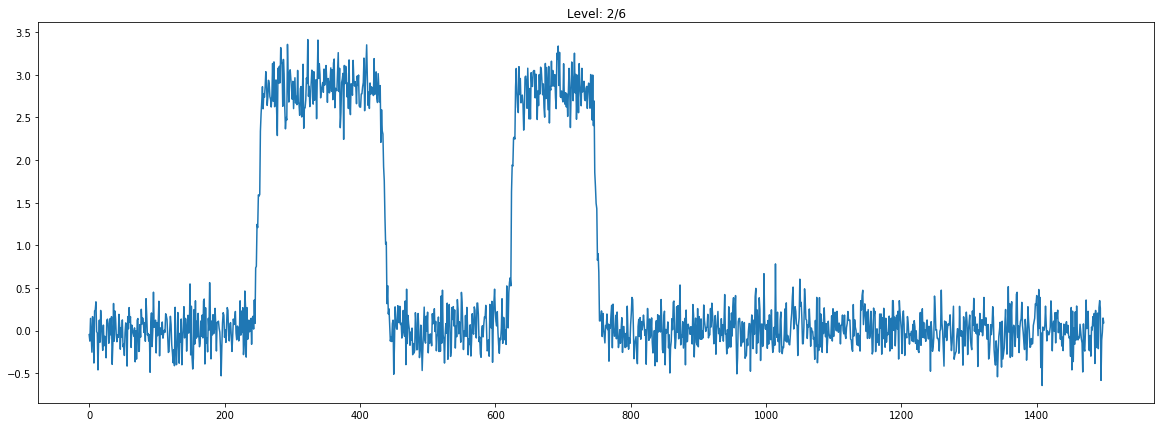

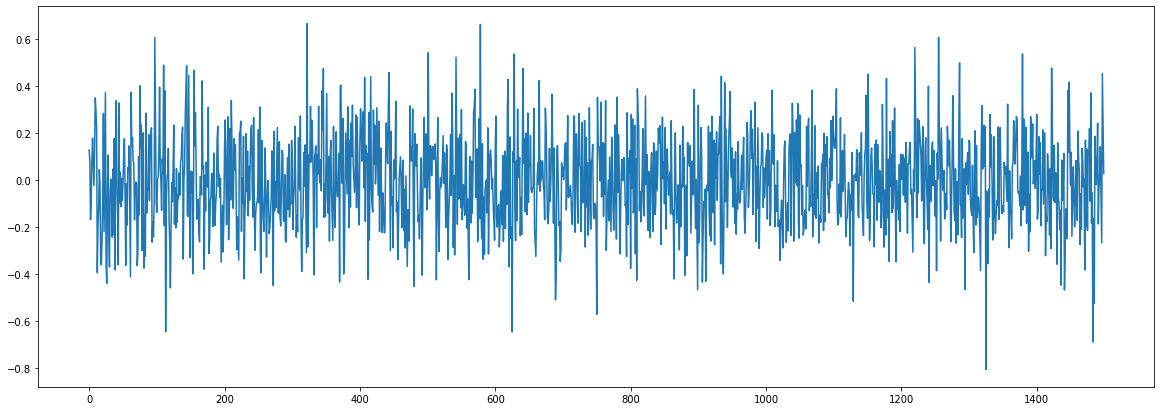

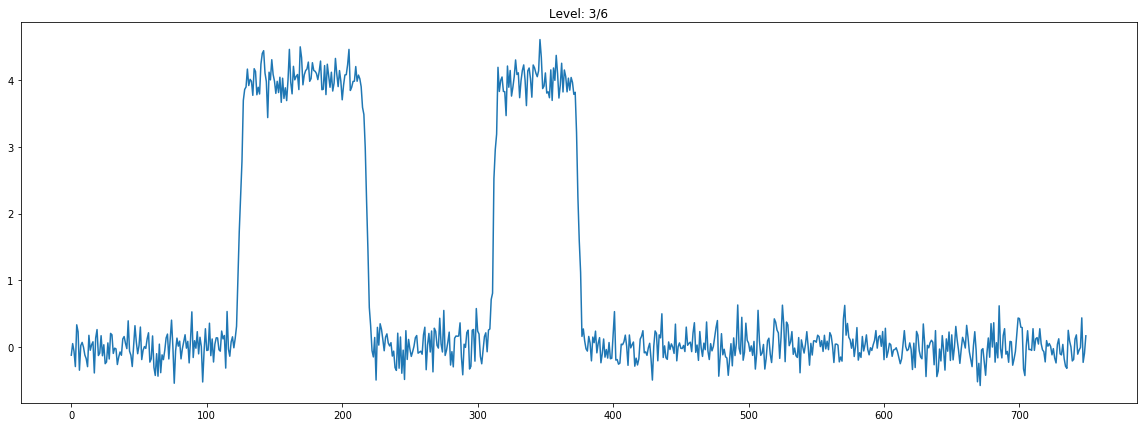

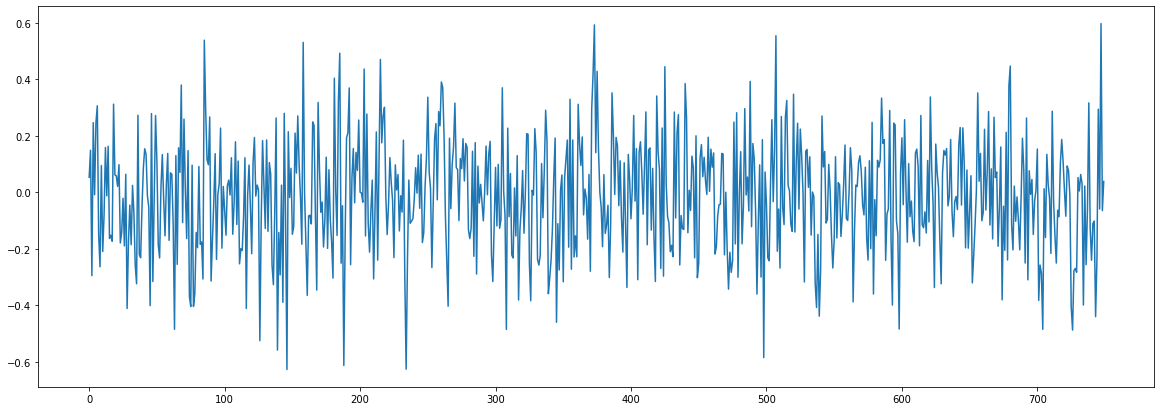

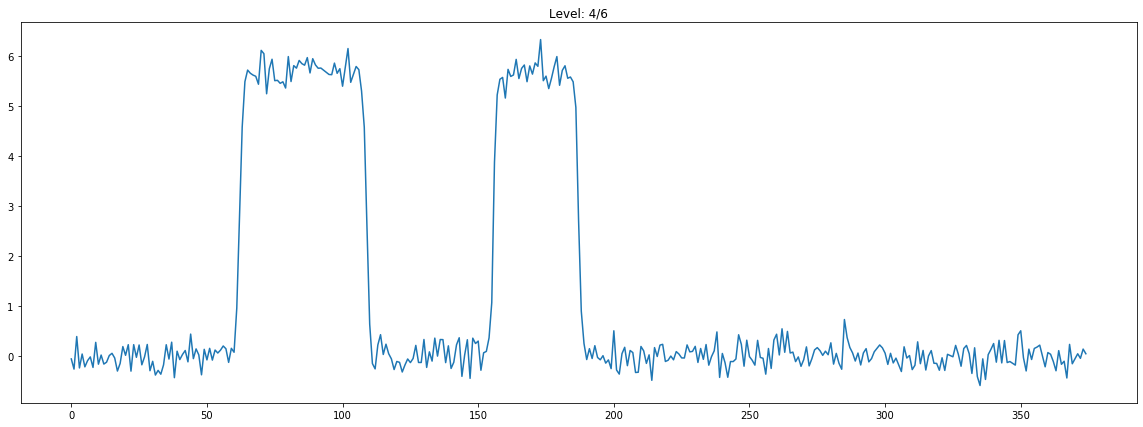

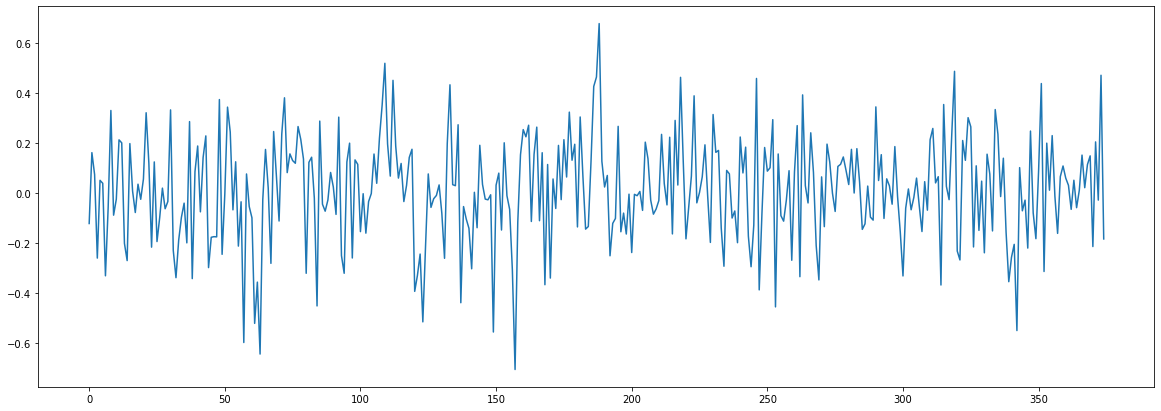

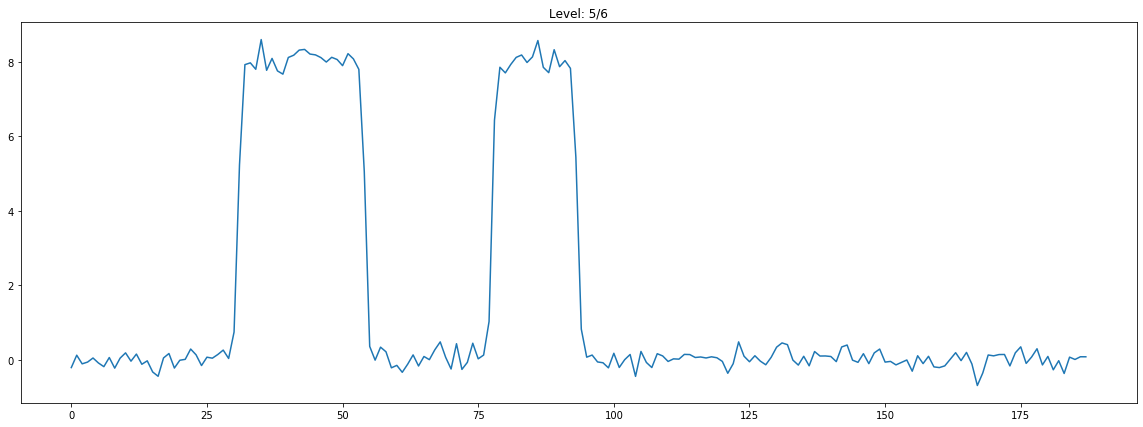

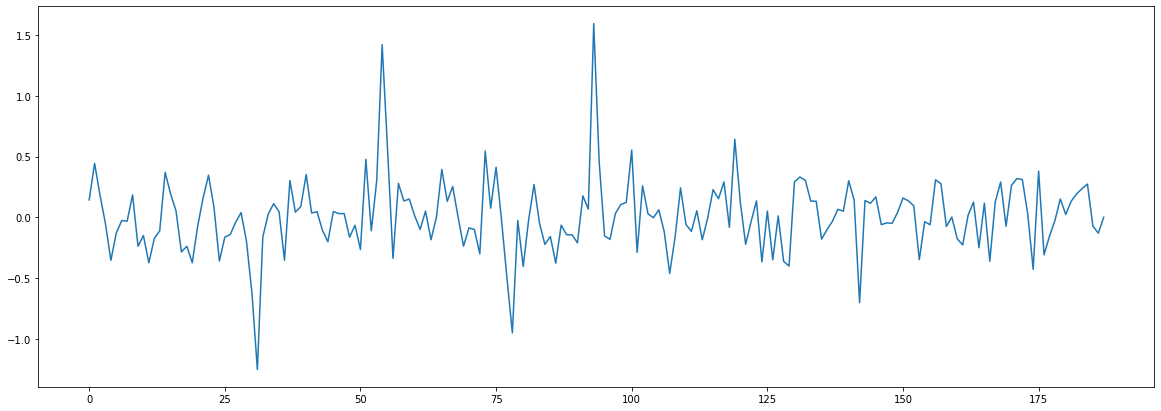

In [5]:
# Subtask b)
level = 6
mode = 'haar'

#Source: 
#https://github.com/PyWavelets/pywt/releases
#pywt/_multilevel.py wavedec
cA_list = [] #rename = []
cD_list = []
cA = signal_filtered_noisy
for i in range(level):
    cA, cD = pywt.dwt(cA, mode) #rename a,d
    cD_list.append(cD)
    cA_list.append(cA)

for i in range(level):
    plt.figure(figsize=(20,7))
    plt.plot(cA_list[i])
    plt.title("Level: {0}/{1}".format(i,level))
    plt.figure(figsize=(20,7))
    plt.plot(cD_list[i])
    plt.show()
    
#The noise is reduced with increasing levels, visually closest result to original signal at level 3 or 4.

Threshold t: 8.81324183685481e+33


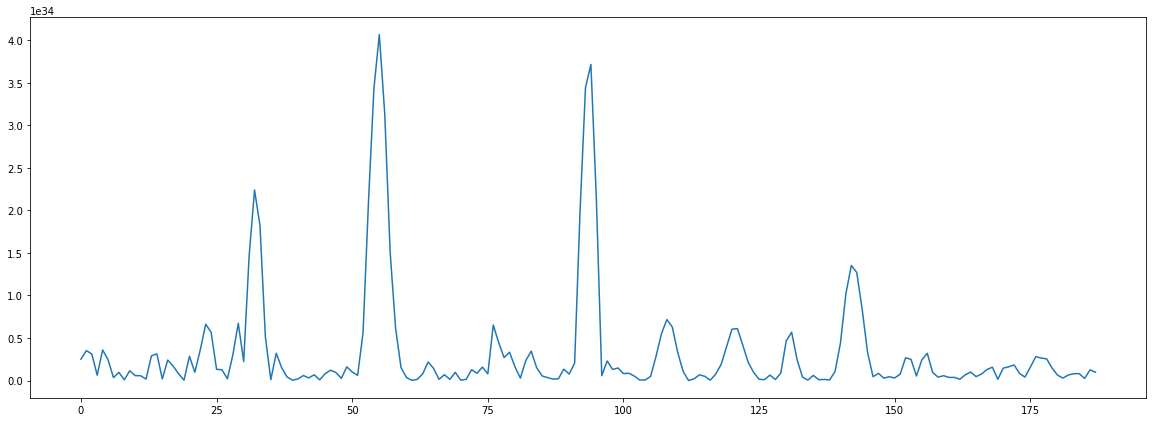

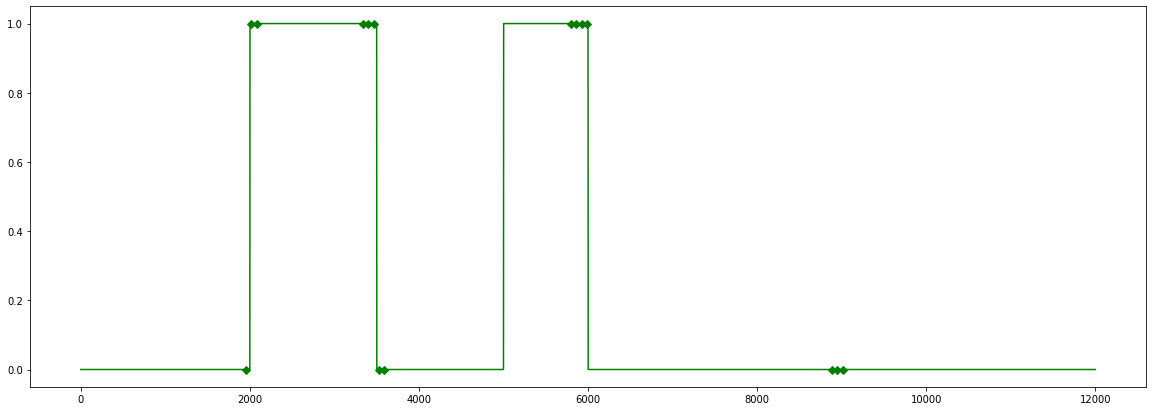

In [6]:
#Subtask c) 
def normalize(X):
    """
    Normalization without centering as defined by paper
    """
    return X/X.std()
        
def scale_product(X, scale, mu, sigma, kernel_sz):
    """
    Scale product P as defined in paper
    """
    psi_j = get_kernel(kernel_sz, mu, sigma, True, scale)
    psi_jpp = get_kernel(kernel_sz, mu, sigma, True, scale+1)
    P1 = (2**scale)*(np.convolve(X, psi_j, 'same'))
    P2 = (2**(scale+1))*np.convolve(X, psi_jpp,'same')
    return np.abs(P1* P2)
    


def get_threshold(mu, sigma, sum_one, scale, kernel_sz):
    """
    Calculate threshold t as defined in paper
    """
    psi_j = get_kernel(kernel_sz, mu, sigma, sum_one, scale)
    psi_jpp = get_kernel(kernel_sz, mu, sigma, sum_one, scale+1)
    sigma_jpp = 0.5*np.linalg.norm(
        psi_j/np.linalg.norm(psi_j)+
        psi_jpp/np.linalg.norm(psi_jpp)
    )
    
    t = 2*(np.linalg.norm(psi_j))*(np.linalg.norm(psi_jpp))*sigma*10**scale
    #t = (4*sigma_jpp)**2
    return t
    
        
#Test algorithm with fixed hyper parameters
coeffictients=5
scale=3
sigma = 0.01
mu = 0.0

X_0 = cD_list[coeffictients]
P_0 = scale_product(X_0, scale, mu, sigma, len(X_0))
t = get_threshold(mu, sigma, True, scale, len(X_0))
print("Threshold t:", t)

upscale_factor = int(len(signal)/len(P_0))
predicted_edges = list([int(upscale_factor*x) for x in list(np.where(P_0>t)[0])])
plt.figure(figsize=(20,7))
plt.plot(P_0)
plt.show()

plt.figure(figsize=(20,7))
plt.plot(signal, '-gD', markevery=predicted_edges)
plt.show()

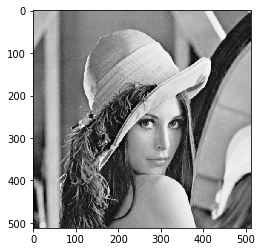

In [7]:
#Task 2.
# Load img from disk
img = PImage.open('./standard_test_images/lena_gray_512.tif')
img = np.asarray(img, dtype=float)
plt.imshow(img, cmap='Greys_r')

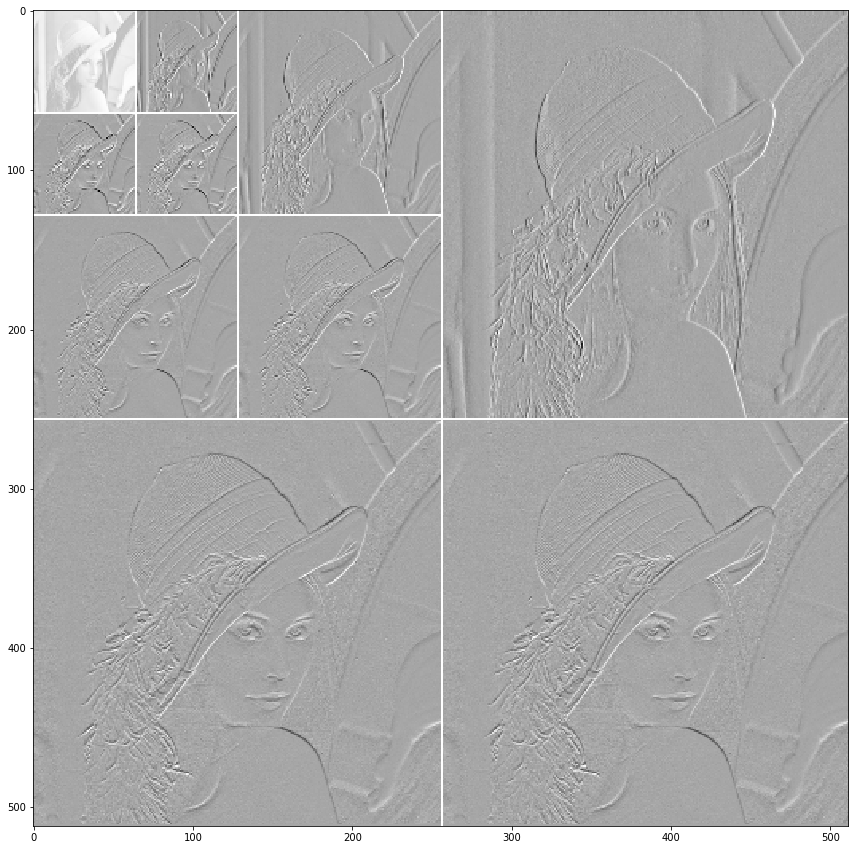

In [8]:
# Subtask a)
level = 4
mode = 'haar'

def resize(X):
    X_new = []
    for row in range(len(X)):
        row_new = np.zeros(int(X[row].shape[0]*0.5))
        x_0 = X[row][0]
        x_1 = X[row][1]
        for i in range(int(len(X[row]))):
            if i%2 == 0:
                x_1 =X[row][i]
                row_new[int(i*0.5)] = (x_0+x_1)*0.5
            else:
                x_0 = X[row][i]
        X_new.append(row_new)
    return np.array(X_new)

def compose_decomposition_image_lvl4(cA_list, cD_list, cH_list, cV_list):
    """
    Build image for decomposition lvl 4
    """
    composed_image = np.zeros(cA_list[0].shape)
    composed_image[:cA_list[3].shape[0], :cA_list[3].shape[1]] = cA_list[3]/np.max(cA_list[3])
    
    #Verticals
    composed_image[cA_list[3].shape[0]:cA_list[3].shape[0]*2, 
                   :cA_list[3].shape[1]] = cV_list[3]/np.max(cV_list[3])
    
    composed_image[cA_list[2].shape[0]:cA_list[2].shape[0]*2, 
                   :cA_list[2].shape[1]] = cV_list[2]/np.max(cV_list[2])
    
    composed_image[cA_list[1].shape[0]:cA_list[1].shape[0]*2, 
                   :cA_list[1].shape[1]] = cV_list[1]/np.max(cV_list[1])
    
    #Horizontals
    composed_image[:cA_list[3].shape[0], 
                   cA_list[3].shape[1]:cA_list[3].shape[1]*2] = cH_list[3]/np.max(cH_list[3])
    
    composed_image[:cA_list[2].shape[0], 
                   cA_list[2].shape[1]:cA_list[2].shape[1]*2] = cH_list[2]/np.max(cH_list[2])
    
    composed_image[:cA_list[1].shape[0], 
                   cA_list[1].shape[1]:cA_list[1].shape[1]*2] = cH_list[1]/np.max(cH_list[1])
    #Diagonals
    composed_image[cA_list[3].shape[0]:cA_list[3].shape[0]*2, 
                   cA_list[3].shape[1]:cA_list[3].shape[1]*2] = cD_list[3]/np.max(cD_list[3])
    
    composed_image[cA_list[2].shape[0]:cA_list[2].shape[0]*2, 
                   cA_list[2].shape[1]:cA_list[2].shape[1]*2] = cD_list[2]/np.max(cD_list[2])
    
    composed_image[cA_list[1].shape[0]:cA_list[1].shape[0]*2, 
                   cA_list[1].shape[1]:cA_list[1].shape[1]*2] = cD_list[1]/np.max(cD_list[1])
    
    #Draw Lines
    composed_image[:cA_list[1].shape[0]*2, 
                   cA_list[1].shape[1]] = 1.0
    
    composed_image[cA_list[1].shape[0], 
                   :cA_list[1].shape[1]*2] = 1.0
    
    composed_image[cA_list[2].shape[0], 
                   :cA_list[2].shape[1]*2] = 1.0
    
    composed_image[:cA_list[2].shape[0]*2, 
                   cA_list[2].shape[1]] = 1.0
    
    composed_image[:cA_list[3].shape[0]*2, 
                   cA_list[3].shape[1]] = 1.0
    
    composed_image[cA_list[3].shape[0], 
                   :cA_list[3].shape[1]*2] = 1.0

    composed_image = composed_image/np.max(composed_image)
    
    return composed_image
    
def decompose2d(img, wavelet, level):
    """
    2D decomposition as defined in assignemnt/gonzalez-woods book
    """
    cH_level_list = [img]
    cV_level_list = [img]
    cA_level_list = [img]
    cD_level_list = [img]
    for level in range(1, level):
        #print(level)
        #print(cA_level_list[level-1].shape)
        rows_cA = []
        rows_cD = []
        for row in range(cA_level_list[level-1].shape[0]):
            cA, cD = pywt.dwt(cA_level_list[level-1][row], mode)
            rows_cD.append(cD)
            rows_cA.append(cA)
        rows_cA = np.array(rows_cA)
        rows_cA_T = rows_cA.T
        cH_level_list.append(resize(np.array(rows_cD).T).T)
        
        columns_cA = []
        columns_cD = []
        for column in range(rows_cA_T.shape[0]):
            cA, cD = pywt.dwt(rows_cA_T[column], mode)
            columns_cD.append(cD)
            columns_cA.append(cA)
        columns_cD = np.array(columns_cD)
        columns_cD = columns_cD.T
        columns_cA = np.array(columns_cA)
        columns_cA = columns_cA.T

        cD_level_list.append(columns_cD)
        cA_level_list.append(columns_cA)
        
    for level in range(1, len(cA_level_list)):
        #print(level)
        #print(cA_level_list[level-1].T.shape)
        columns_cA = []
        columns_cD = []
        for column in range(cA_level_list[level-1].T.shape[0]):
            cA, cD = pywt.dwt(np.array(cA_level_list[level-1]).T[column], mode)
            columns_cD.append(cD)
            columns_cA.append(cA)
        cV_level_list.append(resize(np.array(columns_cD).T))
        
    return cA_level_list, cD_level_list, cH_level_list, cV_level_list

cA_list, cD_list, cH_list, cV_list  = decompose2d(img, mode, level)
composed_image = compose_decomposition_image_lvl4(cA_list, cD_list, cH_list, cV_list)
plt.figure(figsize=(15,15))
plt.imshow(composed_image, cmap = 'Greys_r')

CA
Level: 0
(512, 512)


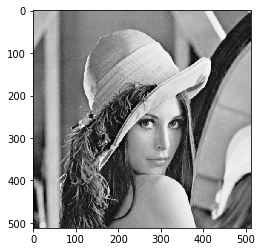

Level: 1
(256, 256)


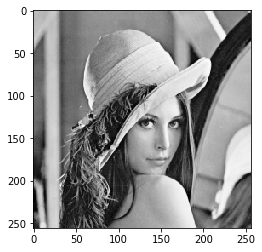

Level: 2
(128, 128)


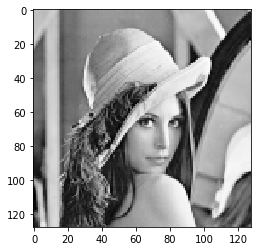

Level: 3
(64, 64)


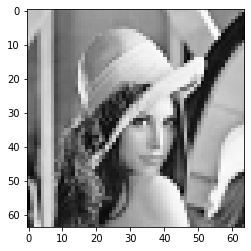

CD
Level: 0
(512, 512)


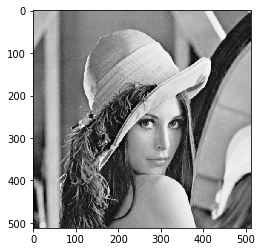

Level: 1
(256, 256)


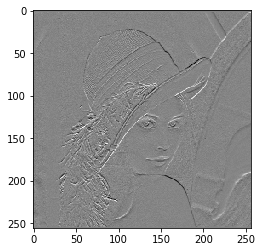

Level: 2
(128, 128)


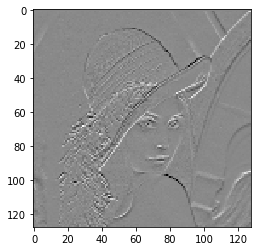

Level: 3
(64, 64)


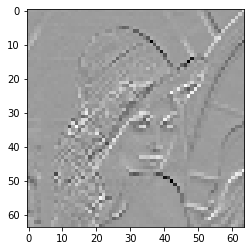

CH
Level: 0
(512, 512)


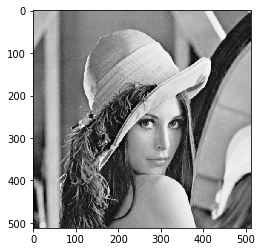

Level: 1
(256, 256)


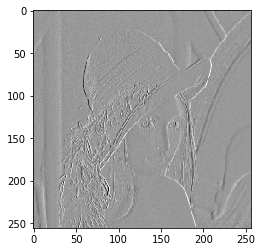

Level: 2
(128, 128)


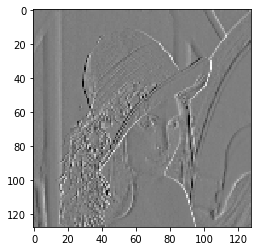

Level: 3
(64, 64)


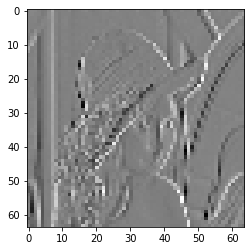

CV
Level: 0
(512, 512)


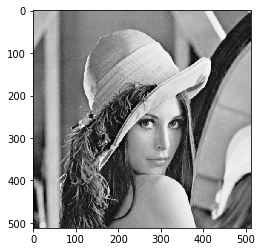

Level: 1
(256, 256)


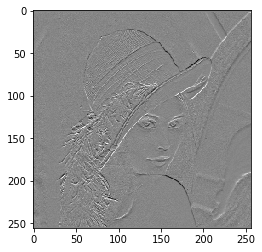

Level: 2
(128, 128)


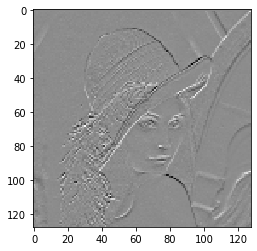

Level: 3
(64, 64)


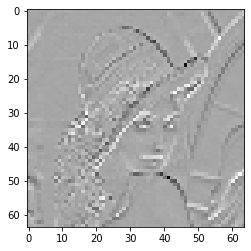

In [9]:
print("CA")
for i in range(level):
    print('Level:', i)
    print(cA_list[i].shape)
    plt.imshow(cA_list[i], cmap = 'Greys_r')
    plt.show()
   
print("CD")
for i in range(level):
    print('Level:', i)
    print(cD_list[i].shape)
    plt.imshow(cD_list[i], cmap = 'Greys_r')
    plt.show()

print("CH")    
for i in range(level):
    print('Level:', i)
    print(cH_list[i].shape)
    plt.imshow(cH_list[i], cmap = 'Greys_r')
    plt.show()

print("CV")    
for i in range(level):
    print('Level:', i)
    print(cV_list[i].shape)
    plt.imshow(cV_list[i], cmap = 'Greys_r')
    plt.show()

In [10]:
#Subtask b)
from IPython.display import display, clear_output #required for showing progress

def nth_gradient2d(X, n, dim):
    """
    N-th numerical differention
    """
    grad = X
    if n > 0:
        for i in range(n):
            dx = 1
            grad = np.gradient(grad, dx, axis=dim)
    return grad

def get_kernel2d(sz, mu=0.0, sigma=0.5, sum_one=False, derivative = 0, axis = 0):
    """
    Differentable 2D kernel θ  with integral == 1
    """
    #2.1 Construct kernel
    kernel = np.linspace(-10.0,10.0,sz)
    kernel = np.exp(-(((kernel-mu)**2.0)/(2.0*sigma**2)))
    kernel2d = np.outer(kernel, kernel)
    
    if derivative >= 1.0:
        kernel2d = nth_gradient2d(kernel2d, derivative, axis)

    #2.2 If integral == 1 is required
    if sum_one:
        kernel2d = kernel2d/np.sum(kernel2d)
        
    return kernel2d    

def normalize2d(X):
    """
    Normalization without centering as defined by paper
    """
    return X/X.std()
 
def convolve_2d(X, Y):
    """
    2-dimensional convolution for quadratic images of equal size
    See https://www.researchgate.net/publication/274360447_Multidimensional_convolution_via_a_1D_convolution_algorithm
    """
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]-1, -1, -1):
        for j in range(Z.shape[1]-1, -1, -1):
            for m in range(X.shape[0]):
                for n in range(X.shape[1]):
                    Z[i,j] += X[m, n]*Y[i-m][j-n]
            #print(i,j)
        clear_output(wait=True)
        print("Didnt know we were allowed to use scipy for",
              "2D convolution, so this may take a while.\nCompletion %:", np.round(100.0*(Z.shape[0]-i-1)*(Z.shape[1]-j-1)/
              ((Z.shape[0]-1)*(Z.shape[1]-1)), 2))
        
        Z1 = np.zeros(Z.shape)
        Z1[:int(Z.shape[0]*0.5), :int(Z.shape[1]*0.5)] = Z[int(Z.shape[0]*0.5):, int(Z.shape[1]*0.5):]
        Z1[int(Z.shape[0]*0.5):, int(Z.shape[1]*0.5):] = Z[:int(Z.shape[0]*0.5), :int(Z.shape[1]*0.5)]
        Z1[:int(Z.shape[0]*0.5), int(Z.shape[1]*0.5):] = Z[int(Z.shape[0]*0.5):, :int(Z.shape[1]*0.5)]
        Z1[int(Z.shape[0]*0.5):, :int(Z.shape[1]*0.5)] = Z[:int(Z.shape[0]*0.5), int(Z.shape[1]*0.5):]
    return Z1
            
        
def scale_product2d(X, scale, mu, sigma, kernel_sz, axis): #axis not used
    """
    Scale product P as defined in paper
    """
    psi_j = get_kernel2d(kernel_sz, mu, sigma, False, scale)
    psi_jpp = get_kernel2d(kernel_sz, mu, sigma, False, scale+1)
    #signal.convolve2d
    W1 = (2**scale)*(sp_signal.convolve2d(X, psi_j, 'same'))
    W2 = (2**(scale+1))*(sp_signal.convolve2d(X, psi_jpp, 'same'))
    #W1 = (2**scale)*(convolve_2d(X, psi_j))
    #W2 = (2**(scale+1))*convolve_2d(X, psi_jpp)
    return W1, W2, np.abs(W1* W2)
    


def get_threshold2d(mu, sigma, sum_one, scale, kernel_sz):
    """
    Calculate threshold t as defined in paper
    TODO: Modify for 2D Version, not working yet
    """
    psi_j = get_kernel2d(kernel_sz, mu, sigma, False, scale)
    psi_jpp = get_kernel2d(kernel_sz, mu, sigma, False, scale+1)
    sigma_jpp = 0.5*np.linalg.norm(
        psi_j/np.linalg.norm(psi_j)+
        psi_jpp/np.linalg.norm(psi_jpp)
    )
    
    t = 2*(np.linalg.norm(psi_j))*(np.linalg.norm(psi_jpp))*sigma*10**scale
    return t

def modulus_2d(P1, P2):
    return np.sqrt(P1+P2)

def angle_2d(W1, W2, P1, P2, x, y):
    upper = np.sign(W2[x,y])*np.sqrt(P2[x,y])
    lower = np.sign(W1[x,y])*np.sqrt(P1[x,y])
    return np.arctan(upper/lower)

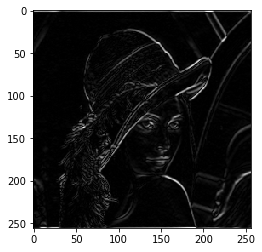

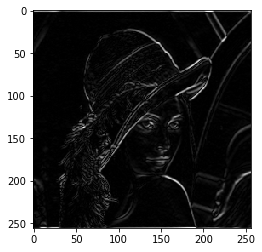

In [11]:
coeffictients=2
scale=0
sigma = 0.05
mu = 0.0

X_0 = cA_list[1]
W1_1, W2_1, P_1 = scale_product2d(X_0, scale, mu, sigma, X_0.shape[0], axis=0)
W1_2, W2_2, P_2 = scale_product2d(X_0, scale, mu, sigma, X_0.shape[0], axis=1)
plt.imshow(P_1, cmap = 'Greys_r')
plt.show()

plt.imshow(P_2, cmap = 'Greys_r')
plt.show()

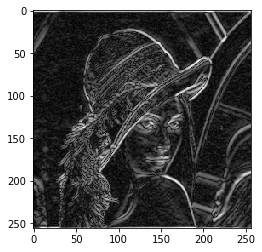

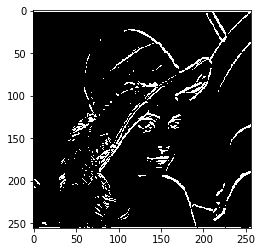

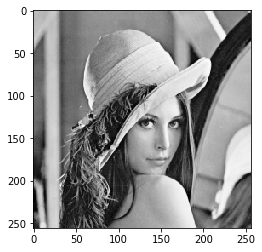

In [12]:
t = get_threshold2d(mu, sigma, False, scale, X_0.shape[0])
M = modulus_2d(P_1, P_2)

#A = np.zeros(X_0.shape)
#for i in range(X_0.shape[0]):
#    for j in range(X_0.shape[1]):
#        A[i][j] = angle_2d(W1_1, W2_1, P1 ,P2, i, j)
#             
t = np.max(M)*0.375

# Plot gradients:
#plt.imshow(A, cmap = 'Greys_r')
#plt.show()

# Plot edgemap
plt.imshow(M, cmap = 'Greys_r')
plt.show()

# Apply thresholding
M[np.where(M<t)] = 0.0
M[np.where(M>=t)] = 1.0

plt.imshow(M, cmap = 'Greys_r')
plt.show()

plt.imshow(X_0, cmap = 'Greys_r')
plt.show()